# Link Prediction : 7가지 = 동일한 커뮤니티 (그래프 전체), 다른 커뮤니티 (서로 다른 서브그래프들)
- [참고] https://brain-nim.tistory.com/m/76  

## 1. 하나의(동일한) community에서 링크를 예측하는 휴리스틱한 방법들 : Heuristics = CN, Jaccard, RA, AA, PA
- CN 에서 거리 2인 경로 구하는 과정만 추가되고, 이후의 계산은 모두 `networkx` 라이브러리 사용  
  
1. `CN (Common Neighbors)` : $CN(x,y)=|N(x)\cap N(y)|$  
  
2. `Jaccard Coefficient` : $J(x,y)=\frac{|N(x)\cap N(y)|}{|N(x)\cup N(y)|}$  
  
3. `RA (Resource Allocation)` : $RA(x,y)=\sum_{v\in N(x)\cap N(y)}\frac{1}{|N(v)|}$  
  
4. `AA (Adamic-Adar Index)` : $AA(x,y)=\sum_{v\in N(x)\cap N(y)}\frac{1}{\log |N(v)|}$  
  
5. `PA (Preferential Attachment Model, Barabasi Albert Model)` : $PA(x,y)=|N(x)||N(y)|$  

### 1-0. 예제 그래프 만들기 : 하나의 커뮤니티만 다루기 때문에 그래프 전체를 생각 
- $G=(V,E),~~|V|=9,~~ |E|=12$  
  
- 나중에 Cora dataset 으로 만든 그래프 넣어서 실험하면 됨

In [2]:
import os
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch_geometric.datasets import Planetoid#, CoraFull
import torch_geometric.transforms as T
import networkx as nx
import warnings
warnings.filterwarnings(action='ignore')
## Load Dataset
# load the Cora dataset
dataset = 'Cora'
path = os.path.join('../', 'data', dataset)
dataset = Planetoid(path, dataset, transform=T.NormalizeFeatures())
data = dataset[0]
print(dataset.data)
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Has isolated nodes: {data.has_isolated_nodes()} -> i.e., no nodes not connected by edges')
print(f'Has self-loops: {data.has_self_loops()} -> i.e., no self-loops')
print(f'Is undirected: {data.is_undirected()} -> i.e., not directional')


Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Has isolated nodes: False -> i.e., no nodes not connected by edges
Has self-loops: False -> i.e., no self-loops
Is undirected: True -> i.e., not directional


(2, 10556)
edge example = [[   0    0    0    1    1    1    2    2    2    2    2    3    4    4
     4    4    4    5    5    5    6    6    6    6    7    8    8    8
     9    9   10   10   11   11   12   12   12   12   13   13   14   14
    14   14   14   15   15   15   15   16   16   16   16   17   17   17
    17   17   18   18   18   18   18   19   20   20   20   20   20   21
    21   22   22   22   22   22   23   24   24   24   24   24   24   24
    25   25   25   25   26   26   26   26   26   27   27   27   27   28
    29   29]
 [ 633 1862 2582    2  652  654    1  332 1454 1666 1986 2544 1016 1256
  1761 2175 2176 1629 1659 2546  373 1042 1416 1602  208  269  281 1996
   723 2614  476 2545 1655 1839 1001 1318 2661 2662 1701 1810  158 2034
  2075 2077 2668 1090 1093 1271 2367  970 1632 2444 2642   24  927 1315
  1316 2140  139 1560 1786 2082 2145 1939 1072 2269 2270 2374 2375 1043
  2310   39 1234 1702 1703 2238 2159   17  201  598 1636 1701 2139 2141
  1301 1344 2011 2317   9

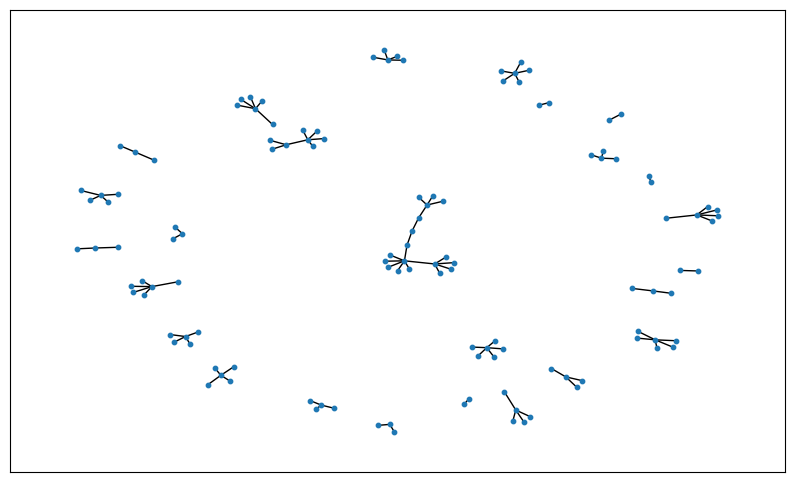

In [23]:
edge_index = data.edge_index.numpy()
print(edge_index.shape)

## Example : edge=6, node=7
edge_example = edge_index[:, np.where(edge_index[0]<30)[0]]
print('edge example = %s' % edge_example)
node_example = np.unique(edge_example.flatten())
print('node example = %s' % node_example)
plt.figure(figsize=(10, 6))
sub_G = nx.Graph()
sub_G.add_nodes_from(node_example)
sub_G.add_edges_from(list(zip(edge_example[0], edge_example[1])))
nx.draw_networkx(G, with_labels=False, node_size=10)

In [12]:
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')

Average node degree: 3.90


,count,mean,std,min,25%,50%,75%,max
0,2708.0,3.9,5.23,1.0,2.0,3.0,5.0,168.0


2708
10556


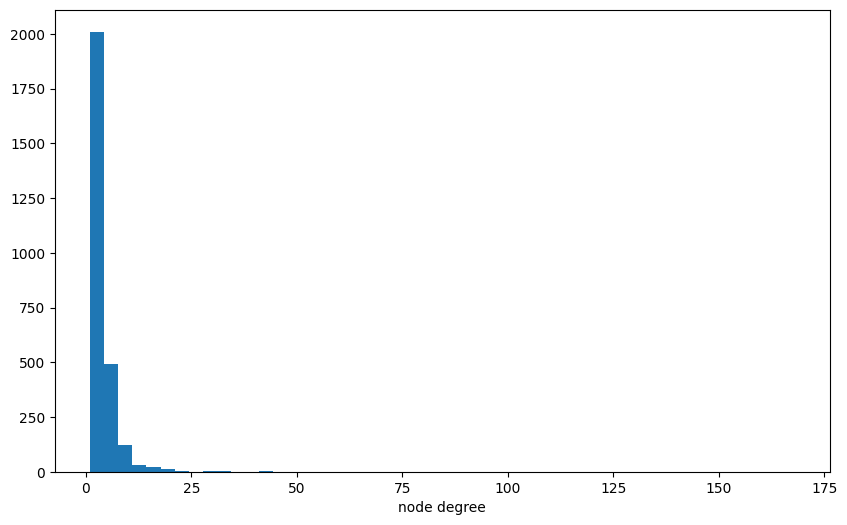

In [13]:
import pandas as pd
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
degrees = [val for (node, val) in G.degree()]
display(pd.DataFrame(pd.Series(degrees).describe()).transpose().round(2))
print(len(degrees))
print(sum(degrees))
plt.figure(figsize=(10, 6))
plt.hist(degrees, bins=50)
plt.xlabel("node degree")
plt.show()

threshold 0.011821204285186553


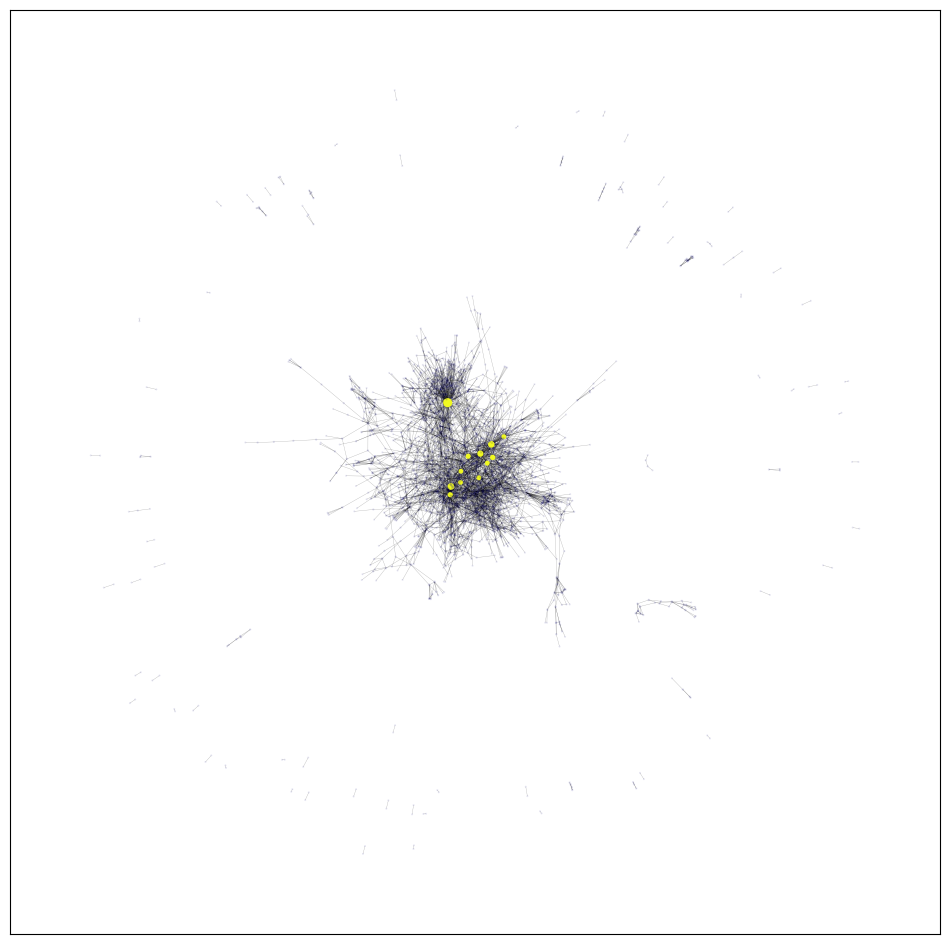

In [14]:
## Cora data nx.draw
G = to_networkx(data, to_undirected=True)
pos = nx.spring_layout(G, seed=42)
cent = nx.degree_centrality(G)
node_size = list(map(lambda x: x * 500, cent.values()))
cent_array = np.array(list(cent.values()))
threshold = sorted(cent_array, reverse=True)[10]
print("threshold", threshold)
cent_bin = np.where(cent_array >= threshold, 1, 0.1)
plt.figure(figsize=(12, 12))
nodes = nx.draw_networkx_nodes(G, pos, node_size=node_size,
                               cmap=plt.cm.plasma,
                               node_color=cent_bin,
                               nodelist=list(cent.keys()),
                               alpha=cent_bin)
edges = nx.draw_networkx_edges(G, pos, width=0.25, alpha=0.3)
plt.show()

### 1-1. `CN (Common Neighbors)`  
- $CN(x,y)=|N(x)\cap N(y)|$  
    where $x,y$ : nodes and $N(x), N(y)$ : neighborhoods of $x,y$ (respectively)  
  
- [예] $CN(A,C)=|\{B,D\}|=2$  
  
- 알고리즘 순서  
    a. 비연결 node pair 구하기  
  
    b. 거리 2인 경로 구하기  
    - 방법 : a 에서 구한 각 비연결 노드 pair에 대한 (1-hop) 이웃 노드를 거치면 거리 2인 경로  
    - `nx.common_neighbors(G, u, v)` where $G$ : undirected graph and $u,v$ : nodes  
    - https://networkx.org/documentation/stable/reference/generated/networkx.classes.function.common_neighbors.html
  
    c. 각 node pair 마다 길이 2인 경로의 개수 세기

In [24]:
## (1) CN (Common Neighbors) 
#### 엣지 연결이 없는 노드쌍
non_edges = list(nx.non_edges(sub_G))
print(non_edges)

[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (0, 16), (0, 17), (0, 18), (0, 19), (0, 20), (0, 21), (0, 22), (0, 23), (0, 24), (0, 25), (0, 26), (0, 27), (0, 28), (0, 29), (0, 1560), (0, 2075), (0, 2077), (0, 281), (0, 2082), (0, 1315), (0, 1316), (0, 1318), (0, 39), (0, 1839), (0, 1072), (0, 2614), (0, 2360), (0, 2367), (0, 1344), (0, 1090), (0, 1602), (0, 1093), (0, 2374), (0, 2375), (0, 269), (0, 332), (0, 2642), (0, 2645), (0, 598), (0, 2139), (0, 2140), (0, 1629), (0, 606), (0, 2141), (0, 1632), (0, 2145), (0, 99), (0, 1636), (0, 2661), (0, 2662), (0, 2310), (0, 2668), (0, 2159), (0, 373), (0, 1655), (0, 122), (0, 1659), (0, 1042), (0, 123), (0, 2175), (0, 1043), (0, 2176), (0, 1666), (0, 1416), (0, 2317), (0, 139), (0, 652), (0, 2444), (0, 654), (0, 1301), (0, 1810), (0, 1939), (0, 2454), (0, 1687), (0, 2455), (0, 158), (0, 927), (0, 1701), (0, 1702), (0, 1703), (0, 2578), (0, 1454), (0, 2238), (0, 1

In [27]:
#### 길이 2인 경로 구하기 : 
CN = {}
for s,t in non_edges:
    print(s,t, list(nx.common_neighbors(sub_G,s,t))) 
## A-C는 경로 2개라는 거임 -> 길이 2인 경로가 가장 많음 

0 1 []
0 2 []
0 3 []
0 4 []
0 5 []
0 6 []
0 7 []
0 8 []
0 9 []
0 10 []
0 11 []
0 12 []
0 13 []
0 14 []
0 15 []
0 16 []
0 17 []
0 18 []
0 19 []
0 20 []
0 21 []
0 22 []
0 23 []
0 24 []
0 25 []
0 26 []
0 27 []
0 28 []
0 29 []
0 1560 []
0 2075 []
0 2077 []
0 281 []
0 2082 []
0 1315 []
0 1316 []
0 1318 []
0 39 []
0 1839 []
0 1072 []
0 2614 []
0 2360 []
0 2367 []
0 1344 []
0 1090 []
0 1602 []
0 1093 []
0 2374 []
0 2375 []
0 269 []
0 332 []
0 2642 []
0 2645 []
0 598 []
0 2139 []
0 2140 []
0 1629 []
0 606 []
0 2141 []
0 1632 []
0 2145 []
0 99 []
0 1636 []
0 2661 []
0 2662 []
0 2310 []
0 2668 []
0 2159 []
0 373 []
0 1655 []
0 122 []
0 1659 []
0 1042 []
0 123 []
0 2175 []
0 1043 []
0 2176 []
0 1666 []
0 1416 []
0 2317 []
0 139 []
0 652 []
0 2444 []
0 654 []
0 1301 []
0 1810 []
0 1939 []
0 2454 []
0 1687 []
0 2455 []
0 158 []
0 927 []
0 1701 []
0 1702 []
0 1703 []
0 2578 []
0 1454 []
0 2238 []
0 1986 []
0 963 []
0 201 []
0 970 []
0 1996 []
0 208 []
0 1234 []
0 723 []
0 2011 []
0 476 []
0 2269 []


In [28]:
## (1) CN (Common Neighbors) 
# 엣지 연결이 없는 노드쌍
non_edges = list(nx.non_edges(sub_G))
# print(non_edges)

# 공통이웃 수 count 딕셔너리 생성
common_neighbors_count = {}
for n1,n2 in non_edges:
    common_neighbors_count[(n1, n2)] = len(list(nx.common_neighbors(sub_G, n1, n2)))
    # print(common_neighbors_count)
sorted(common_neighbors_count.items(), key=lambda x: x[1], reverse=True)

[((1, 332), 1),
 ((1, 1666), 1),
 ((1, 1454), 1),
 ((1, 1986), 1),
 ((2, 652), 1),
 ((2, 654), 1),
 ((13, 24), 1),
 ((13, 27), 1),
 ((17, 598), 1),
 ((17, 2139), 1),
 ((17, 2141), 1),
 ((17, 1636), 1),
 ((17, 1701), 1),
 ((17, 201), 1),
 ((24, 1315), 1),
 ((24, 1316), 1),
 ((24, 2140), 1),
 ((24, 927), 1),
 ((1560, 2082), 1),
 ((1560, 2145), 1),
 ((1560, 139), 1),
 ((1560, 1786), 1),
 ((2075, 2077), 1),
 ((2075, 2668), 1),
 ((2075, 158), 1),
 ((2075, 2034), 1),
 ((2077, 2668), 1),
 ((2077, 158), 1),
 ((2077, 2034), 1),
 ((2082, 2145), 1),
 ((2082, 139), 1),
 ((2082, 1786), 1),
 ((39, 1702), 1),
 ((39, 1703), 1),
 ((39, 2238), 1),
 ((39, 1234), 1),
 ((1072, 2374), 1),
 ((1072, 2375), 1),
 ((1072, 2269), 1),
 ((1072, 2270), 1),
 ((2614, 723), 1),
 ((1090, 2367), 1),
 ((1090, 1093), 1),
 ((1090, 1271), 1),
 ((1602, 1042), 1),
 ((1602, 373), 1),
 ((1602, 1416), 1),
 ((1093, 2367), 1),
 ((1093, 1271), 1),
 ((2642, 1632), 1),
 ((2642, 2444), 1),
 ((2642, 970), 1),
 ((2645, 963), 1),
 ((598, 

In [ ]:
# from tqdm import tqdm
# from torch_geometric.loader import DataLoader
# def CN(A, edge_index, batch_size=100000):
#     """
#     Common neighbours
#     :param A: scipy sparse adjacency matrix
#     :param edge_index: pyg edge_index
#     :param batch_size: int
#     :return: FloatTensor [edges] of scores, pyg edge_index
#     """
#     link_loader = DataLoader(range(edge_index.size(0)), batch_size)
#     scores = []
#     for ind in tqdm(link_loader):
#         src, dst = edge_index[ind, 0], edge_index[ind, 1]
#         cur_scores = np.array(np.sum(A[src].multiply(A[dst]), 1)).flatten()
#         scores.append(cur_scores)
#     scores = np.concatenate(scores, 0)
#     print(f'evaluated Common Neighbours for {len(scores)} edges')
#     return torch.FloatTensor(scores), edge_index

# A = nx.adjacency_matrix(G)
# score, edge_index = CN(A, data.edge_index)
# print(score, edge_index, sep='\n')

### 1-2. `Jaccard Coefficient (- index, - similarity)`  
- $J(x,y)=\frac{|N(x)\cap N(y)|}{|N(x)\cup N(y)|}$  
  
- [예] $J(A,C)=\frac{|\{B,D\}|}{|\{B,D,E,F\}|}=\frac{2}{4}=0.5$  
  
- `nx.jaccard_coefficient(G, ebunch=None)`  where `ebunch` : iterable of node pairs, optional (default = None)  
  
- https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.link_prediction.jaccard_coefficient.html#networkx.algorithms.link_prediction.jaccard_coefficient 

In [29]:
## (2) Jaccard
jaccard = list(nx.jaccard_coefficient(sub_G))
print('unsorted jaccard index :\n%s' % jaccard)
jaccard = sorted(jaccard, key=lambda x: x[2], reverse=True)  
print('---------------------------------------------------')
# jaccard.sort(key=lambda x: x[2], reverse=True)  
# print('Jaccard = %s' % jaccard)
for u,v,j in jaccard:
    print(f"({u},{v}) -> {j}")#:.8f}")

unsorted jaccard index :
[(0, 1, 0.0), (0, 2, 0.0), (0, 3, 0.0), (0, 4, 0.0), (0, 5, 0.0), (0, 6, 0.0), (0, 7, 0.0), (0, 8, 0.0), (0, 9, 0.0), (0, 10, 0.0), (0, 11, 0.0), (0, 12, 0.0), (0, 13, 0.0), (0, 14, 0.0), (0, 15, 0.0), (0, 16, 0.0), (0, 17, 0.0), (0, 18, 0.0), (0, 19, 0.0), (0, 20, 0.0), (0, 21, 0.0), (0, 22, 0.0), (0, 23, 0.0), (0, 24, 0.0), (0, 25, 0.0), (0, 26, 0.0), (0, 27, 0.0), (0, 28, 0.0), (0, 29, 0.0), (0, 1560, 0.0), (0, 2075, 0.0), (0, 2077, 0.0), (0, 281, 0.0), (0, 2082, 0.0), (0, 1315, 0.0), (0, 1316, 0.0), (0, 1318, 0.0), (0, 39, 0.0), (0, 1839, 0.0), (0, 1072, 0.0), (0, 2614, 0.0), (0, 2360, 0.0), (0, 2367, 0.0), (0, 1344, 0.0), (0, 1090, 0.0), (0, 1602, 0.0), (0, 1093, 0.0), (0, 2374, 0.0), (0, 2375, 0.0), (0, 269, 0.0), (0, 332, 0.0), (0, 2642, 0.0), (0, 2645, 0.0), (0, 598, 0.0), (0, 2139, 0.0), (0, 2140, 0.0), (0, 1629, 0.0), (0, 606, 0.0), (0, 2141, 0.0), (0, 1632, 0.0), (0, 2145, 0.0), (0, 99, 0.0), (0, 1636, 0.0), (0, 2661, 0.0), (0, 2662, 0.0), (0, 2310, 

### 1-3. `RA, Resource Allocation (자원할당)`  
- $RA(x,y)=\sum_{v\in N(x)\cap N(y)}\frac{1}{|N(v)|}$  
  
- [예] $RA(A,C)=\frac{1}{|N(B)|}+\frac{1}{|N(D)|}=\frac{1}{3}+\frac{1}{3}=\frac{2}{3}=0.666\ldots$  
    - $N(A)\cap N(C)=\{B,D,E\}\cap \{B,D,F\}=\{B,D\}$
  
- `resource_allocation_index(G, ebunch=None)`
  
- https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.link_prediction.resource_allocation_index.html

In [30]:
## (3) RA, 자원 할당
resource = list(nx.resource_allocation_index(sub_G))
resource = sorted(resource, key=lambda x: x[2], reverse=True)
for u,v,r in resource:
    print(f"({u},{v}) -> {r}")

(13,24) -> 0.5
(13,27) -> 0.5
(2614,723) -> 0.5
(2645,963) -> 0.5
(1655,1839) -> 0.5
(1043,2310) -> 0.5
(1701,1810) -> 0.5
(476,2545) -> 0.5
(2,652) -> 0.3333333333333333
(2,654) -> 0.3333333333333333
(1629,1659) -> 0.3333333333333333
(1629,2546) -> 0.3333333333333333
(633,2582) -> 0.3333333333333333
(633,1862) -> 0.3333333333333333
(1659,2546) -> 0.3333333333333333
(652,654) -> 0.3333333333333333
(2582,1862) -> 0.3333333333333333
(269,281) -> 0.3333333333333333
(269,1996) -> 0.3333333333333333
(281,1996) -> 0.3333333333333333
(1090,2367) -> 0.25
(1090,1093) -> 0.25
(1090,1271) -> 0.25
(1602,1042) -> 0.25
(1602,373) -> 0.25
(1602,1416) -> 0.25
(1093,2367) -> 0.25
(1093,1271) -> 0.25
(2642,1632) -> 0.25
(2642,2444) -> 0.25
(2642,970) -> 0.25
(606,2578) -> 0.25
(606,1810) -> 0.25
(606,2360) -> 0.25
(1632,2444) -> 0.25
(1632,970) -> 0.25
(2661,1318) -> 0.25
(2661,2662) -> 0.25
(2661,1001) -> 0.25
(2662,1318) -> 0.25
(2662,1001) -> 0.25
(1042,1416) -> 0.25
(1042,373) -> 0.25
(2578,1810) ->

### 1-4. `AA, Adamic Adar`  
- $AA(x,y)=\sum_{v\in N(x)\cap N(y)}\frac{1}{\log|N(v)|}$  
  
- [예] $RA(A,C)=\frac{1}{\log|N(B)|}+\frac{1}{\log|N(D)|}=\frac{1}{\log 3}+\frac{1}{\log 3}=1.820478\ldots$  
  
- `resource_allocation_index(G, ebunch=None)`  
  
- https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.link_prediction.resource_allocation_index.html#networkx.algorithms.link_prediction.resource_allocation_index

In [31]:
## AA
aa = list(nx.adamic_adar_index(sub_G))
aa = sorted(aa, key=lambda x: x[2], reverse=True)
for u,v,a in aa:
    print(f"({u},{v}) -> {a}")

(13,24) -> 1.4426950408889634
(13,27) -> 1.4426950408889634
(2614,723) -> 1.4426950408889634
(2645,963) -> 1.4426950408889634
(1655,1839) -> 1.4426950408889634
(1043,2310) -> 1.4426950408889634
(1701,1810) -> 1.4426950408889634
(476,2545) -> 1.4426950408889634
(2,652) -> 0.9102392266268373
(2,654) -> 0.9102392266268373
(1629,1659) -> 0.9102392266268373
(1629,2546) -> 0.9102392266268373
(633,2582) -> 0.9102392266268373
(633,1862) -> 0.9102392266268373
(1659,2546) -> 0.9102392266268373
(652,654) -> 0.9102392266268373
(2582,1862) -> 0.9102392266268373
(269,281) -> 0.9102392266268373
(269,1996) -> 0.9102392266268373
(281,1996) -> 0.9102392266268373
(1090,2367) -> 0.7213475204444817
(1090,1093) -> 0.7213475204444817
(1090,1271) -> 0.7213475204444817
(1602,1042) -> 0.7213475204444817
(1602,373) -> 0.7213475204444817
(1602,1416) -> 0.7213475204444817
(1093,2367) -> 0.7213475204444817
(1093,1271) -> 0.7213475204444817
(2642,1632) -> 0.7213475204444817
(2642,2444) -> 0.7213475204444817
(2642,97

### 1-5. `PA, Preferential Attachment, Barabasi Albert`
- $PA(x,y)=|N(x)||N(y)|$  
  
- [예] $PA(A,C)=|N(A)||N(C)|=3\times 3=9$  
  
- `preferential_attachment(G, ebunch=None)`  
  
- https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.link_prediction.preferential_attachment.html#networkx.algorithms.link_prediction.preferential_attachment

In [32]:
## (5) PA 
pref = list(nx.preferential_attachment(sub_G))
pref = sorted(pref, key=lambda x: x[2], reverse=True)
for u,v,p in pref:
    print(f"({u},{v}) -> {p}")

(2,24) -> 35
(4,24) -> 35
(14,24) -> 35
(18,24) -> 35
(20,24) -> 35
(22,24) -> 35
(24,26) -> 35
(6,24) -> 28
(12,24) -> 28
(15,24) -> 28
(16,24) -> 28
(24,25) -> 28
(24,27) -> 28
(2,4) -> 25
(2,14) -> 25
(2,17) -> 25
(2,18) -> 25
(2,20) -> 25
(2,22) -> 25
(2,26) -> 25
(4,14) -> 25
(4,17) -> 25
(4,18) -> 25
(4,20) -> 25
(4,22) -> 25
(4,26) -> 25
(14,17) -> 25
(14,18) -> 25
(14,20) -> 25
(14,22) -> 25
(14,26) -> 25
(17,18) -> 25
(17,20) -> 25
(17,22) -> 25
(17,26) -> 25
(18,20) -> 25
(18,22) -> 25
(18,26) -> 25
(20,22) -> 25
(20,26) -> 25
(22,26) -> 25
(0,24) -> 21
(1,24) -> 21
(5,24) -> 21
(8,24) -> 21
(2,6) -> 20
(2,12) -> 20
(2,15) -> 20
(2,16) -> 20
(2,25) -> 20
(2,27) -> 20
(4,6) -> 20
(4,12) -> 20
(4,15) -> 20
(4,16) -> 20
(4,25) -> 20
(4,27) -> 20
(6,14) -> 20
(6,17) -> 20
(6,18) -> 20
(6,20) -> 20
(6,22) -> 20
(6,26) -> 20
(12,14) -> 20
(12,17) -> 20
(12,18) -> 20
(12,20) -> 20
(12,22) -> 20
(12,26) -> 20
(14,15) -> 20
(14,16) -> 20
(14,25) -> 20
(14,27) -> 20
(15,17) -> 20
(15,1

## 2. 서로 다른 커뮤니티에서의 링크 예측 
- `networkx` 라이브러리 이용해서 계산하면 되므로 그래프만 만들면 됨
### 2-0. 예제 그래프 만들기 : 하나의 그래프에서 서로 다른 두 커뮤니티(즉, 두 부분그래프)를 다룰 것임 -> 위와 같은 그래프인데, 두 서브그래프로 나눠서 다룸 
- `community0 = [A,B,C,D]`  
- `community1 = [E,F,G,H,I]`

In [62]:
print(node_example.shape)
community0 = node_example[:50]
community1 = node_example[50:]
print(community0.shape, community1.shape)

(124,)
(50,) (74,)


- node coloring 참고 : https://choiseokwon.tistory.com/172

In [ ]:
# import networkx as nx
# import matplotlib.pyplot as plt

# G = nx.Graph()
# G.add_edge(1,2, weight=5)
# G.add_edge(1,3, weight=6)
# G.add_edge(1,4, weight=2)
# G.add_edge(2,4, weight=1)
# G.add_edge(1,4, weight=0.5)
# pos = nx.spring_layout(G)
# nx.draw(G, pos, with_labels=True)
# labels = nx.get_edge_attributes(G, 'weight')
# print(labels)
# nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

In [71]:
# import networkx as nx
# from torch_geometric.utils.convert import from_networkx

# sub_G_ = from_networkx(sub_G)
# ## community0 ## 빨간색 노드
# ## community1 ## 파란색 노드

# comm_G = nx.Graph()
# comm_G.add_edges_from(sub_G_.edge_index) 
# pos = nx.spring_layout(sub_G_.x, seed=2023) ## positions for all nodes 
# nx.draw(comm_G, pos=pos, with_labels=False, font_color="whitesmoke") 
# nx.draw_networkx_nodes(comm_G, pos, community0, node_color="tab:red")
# nx.draw_networkx_nodes(comm_G, pos, community1, node_color="tab:blue")
# G.add_nodes_from(community0, community=0)
# G.add_nodes_from(community1, community=1)
# G.nodes(data=True)

### 2-1. `Community CN (C.N. Soundarajan-Hopcroft score)`
- "the common neighbors Soundarajan-Hopcroft score of nodes $x$ and $y$"
    - $CCN(x,y):=|N(x)\cap N(y)|+\sum_{v\in N(x)\cap N(y)}f(v)$, where $f(v)= 1$ if $v\in N(x)\cap N(y)$ and 0, otherwise  
  
    - 공통 이웃의 수 $=|N(x)\cap N(y)| = CN(x,y)$  
  
    - 공통 이웃이 같은 커뮤니티에 속하는지의 여부 $=\sum_{v\in N(x)\cap N(y)}f(v)$ 
  
- [예1] $CCN(A,C)=CN(A,C)+\sum_{v\in\{B,D\}}f(v)=|\{B,D\}|+(f(B)+f(D))=2+(1+1)=4$  
  
- [예2] $CCN(F,I)=CN(F,I)+\sum_{v\in\{G\}}f(v)=|\{G\}|+f(G)=1+1=2$  
  
- `cn_soundarajan_hopcroft(G, ebunch=None, community='community')`  
  
- https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.link_prediction.cn_soundarajan_hopcroft.html

In [73]:
cn_s_h = list(nx.cn_soundarajan_hopcroft(sub_G))
cn_s_h = sorted(cn_s_h, key=lambda x: x[2], reverse=True)
for u,v,csh in cn_s_h:
    print(f"({u}, {v}) -> {csh}")

NetworkXAlgorithmError: No community information

### 2-2. `Community RA (Community Resource Allocation)`
- "the Resource Allocation Soundarajan-Hopcroft score of nodes $x$ and $y$"
    - $CRA(x,y):=\sum_{v\in N(x)\cap N(y)}\frac{f(v)}{|N(v)|}$, where $f(v)= 1$ if $v\in N(x)\cap N(y)$ and 0, otherwise  
  
    - 기존 RA 와 비슷하나, 분자에 1 대신 $f(v)$ -> 커뮤니티에 속했는지의 여부도 헤아림 
  
- [예1] $CRA(A,C)=\sum_{v\in\{B,D\}}\frac{f(v)}{|N(v)|}=\frac{f(B)}{|N(B)|}+\frac{f(D)}{|N(D)|}=\frac{1}{3}+\frac{1}{3}=\frac{2}{3}=0.666\ldots$  
  
- [예2] $CRA(F,I)=\sum_{v\in\{G\}}\frac{f(v)}{|N(v)|}=\frac{1}{4}=0.25$  
  
- `ra_index_soundarajan_hopcroft(G, ebunch=None, community='community')`  
  
- https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.link_prediction.ra_index_soundarajan_hopcroft.html#networkx.algorithms.link_prediction.ra_index_soundarajan_hopcroft

In [ ]:
ra_s_h = list(nx.ra_index_soundarajan_hopcroft(G))
ra_s_h = sorted(ra_s_h, key=lambda x: x[2], reverse=True)
for u,v,rsh in ra_s_h:
    print(f"({u}, {v}) -> {rsh}")